In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os

In [2]:
path = 'E:\\Data_Science\\OpenClassRoom\\Projet 5\\archive'
cust_df=pd.read_csv(path + '\\olist_customers_dataset.csv')
geo_df=pd.read_csv(path +'\\olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv(path + '\\olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv(path + '\\olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv(path + '\\olist_order_reviews_dataset.csv')
ord_df=pd.read_csv(path + '\\olist_orders_dataset.csv')
prod_df=pd.read_csv(path + '\\olist_products_dataset.csv')
sell_df=pd.read_csv(path + '\\olist_sellers_dataset.csv')

In [3]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

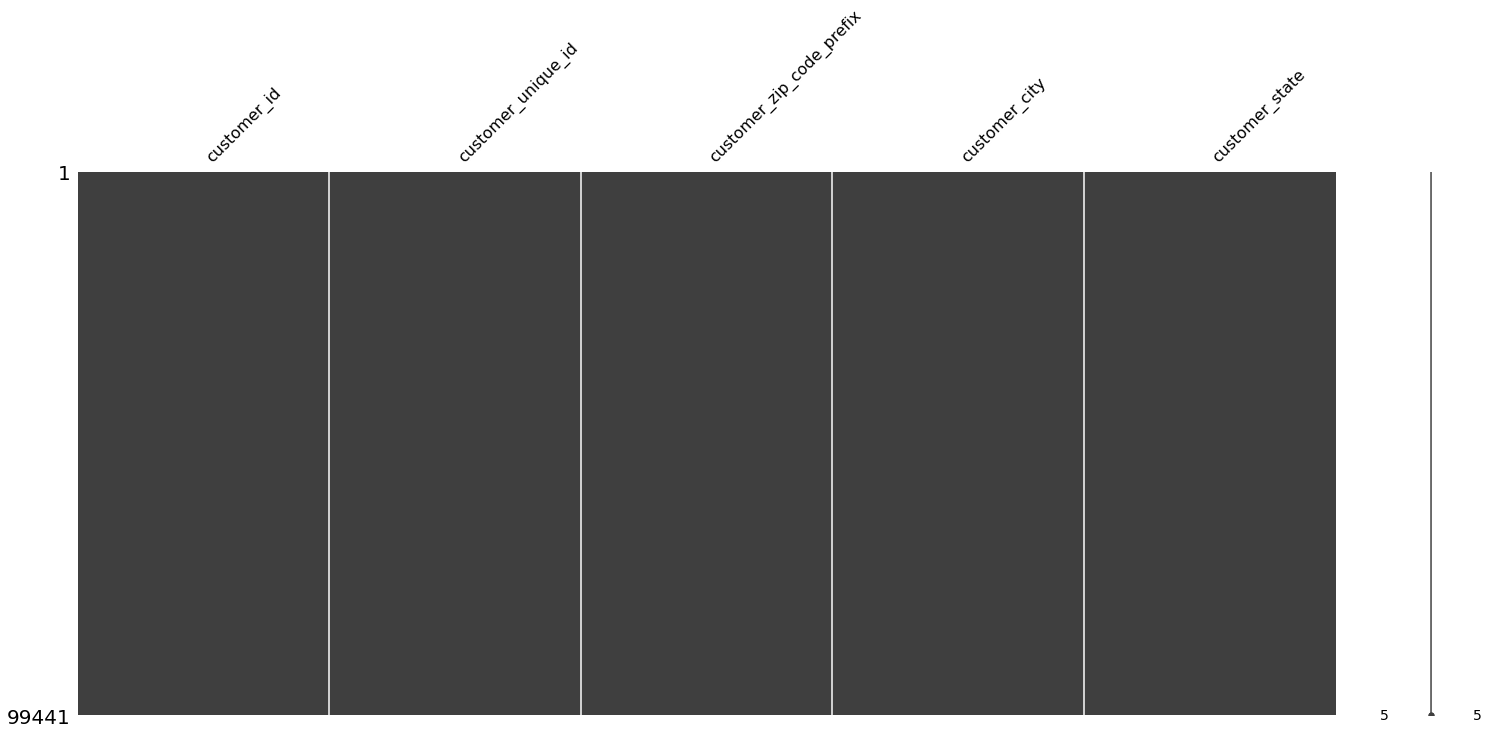

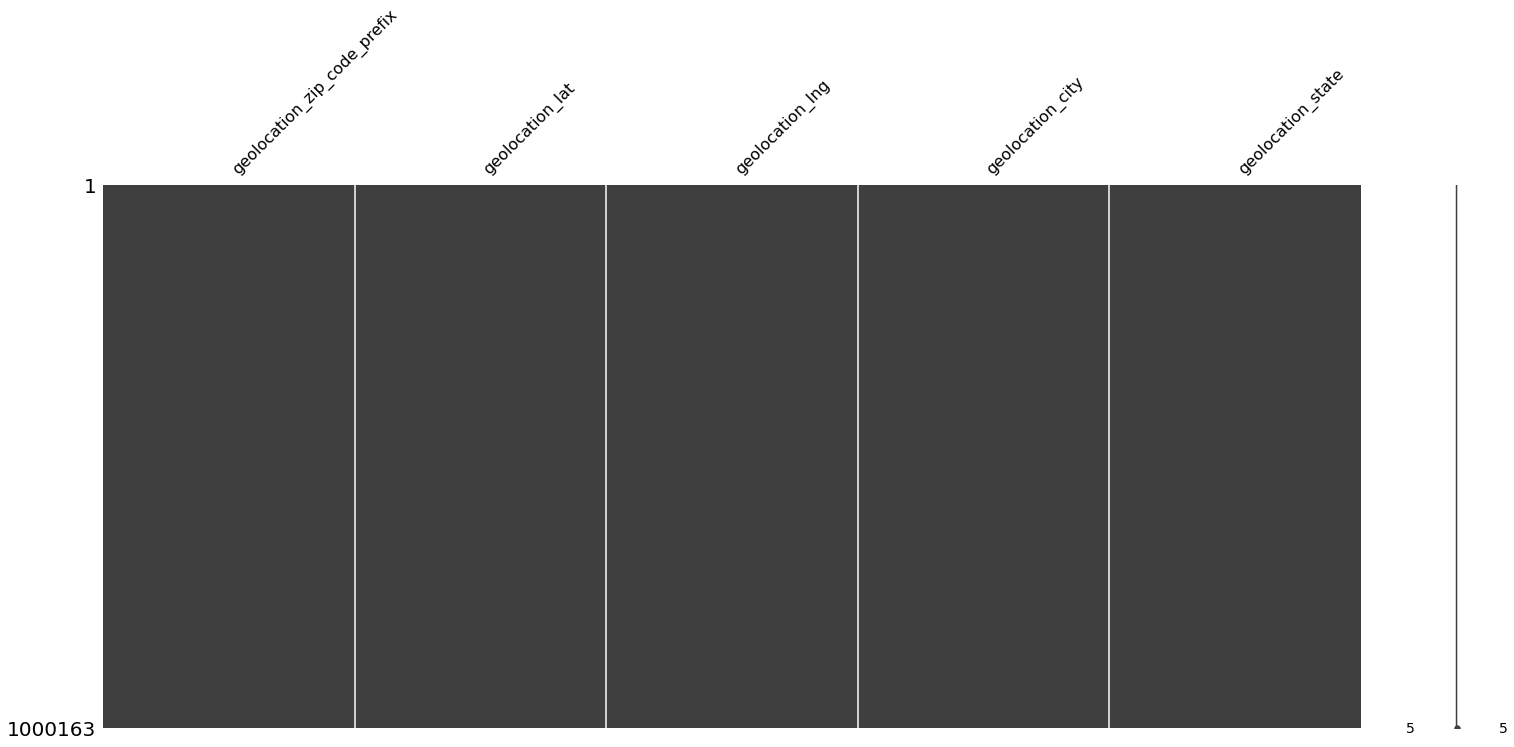

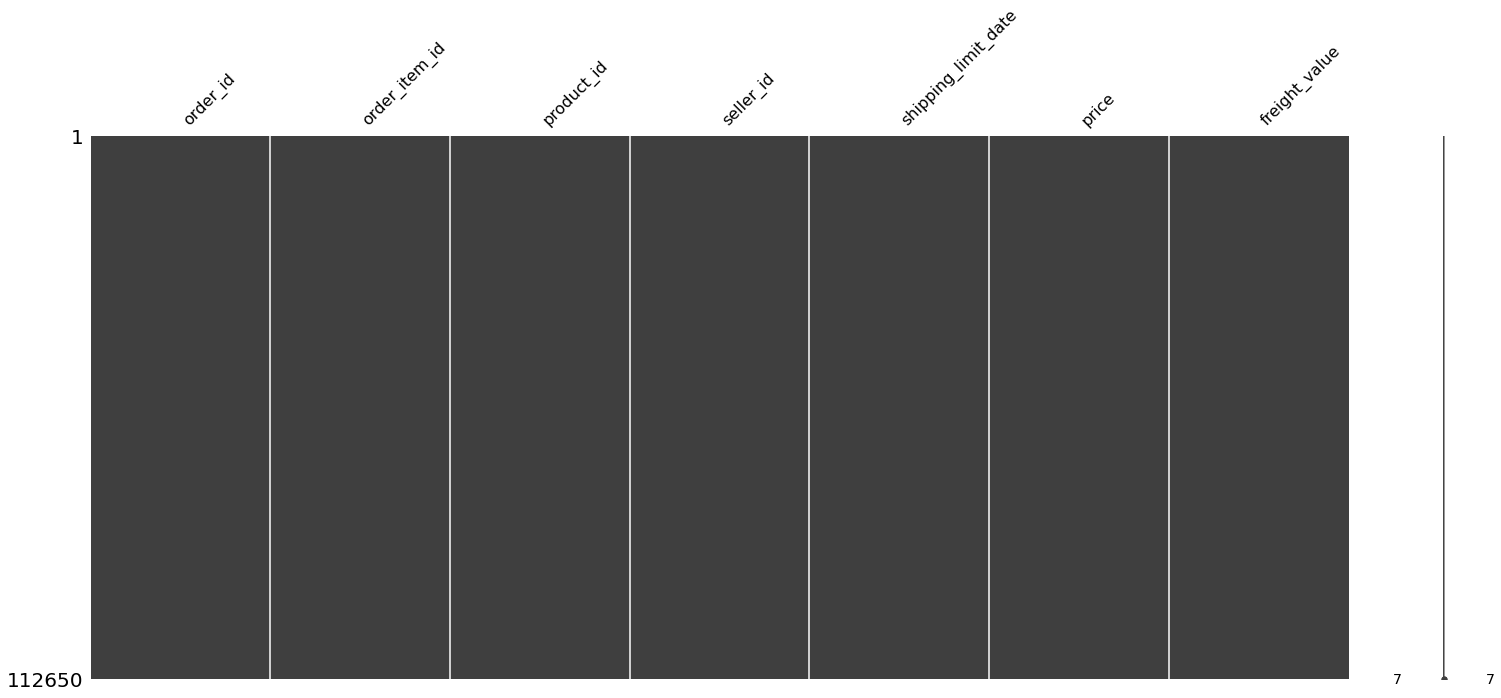

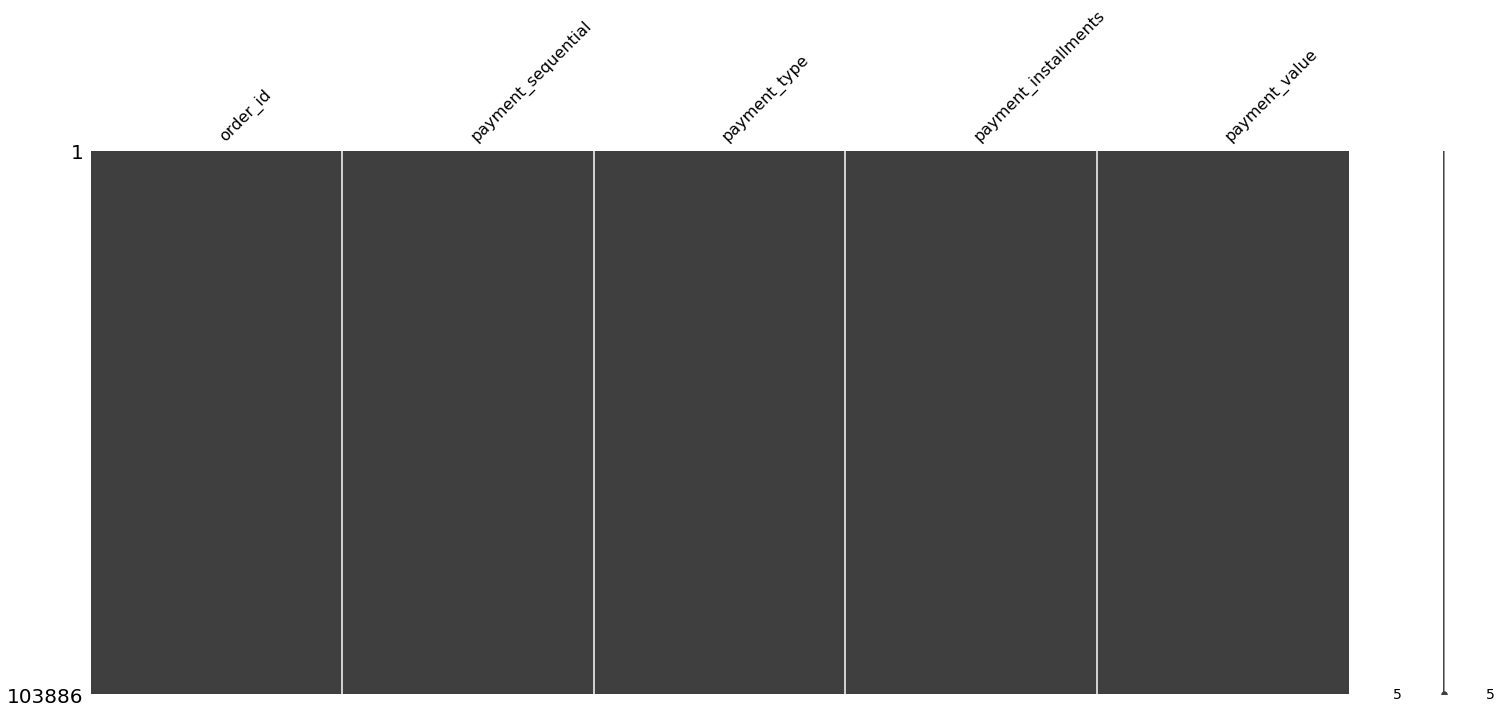

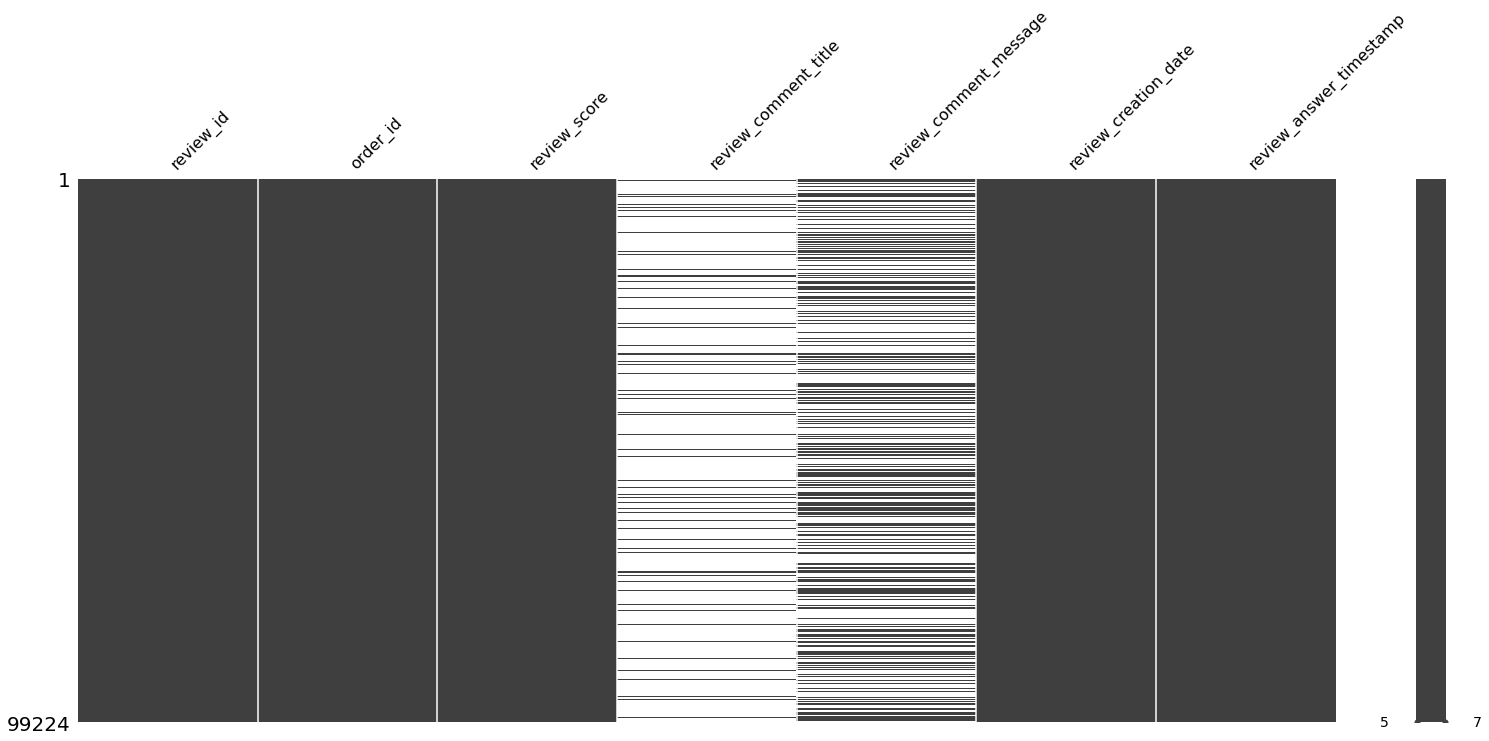

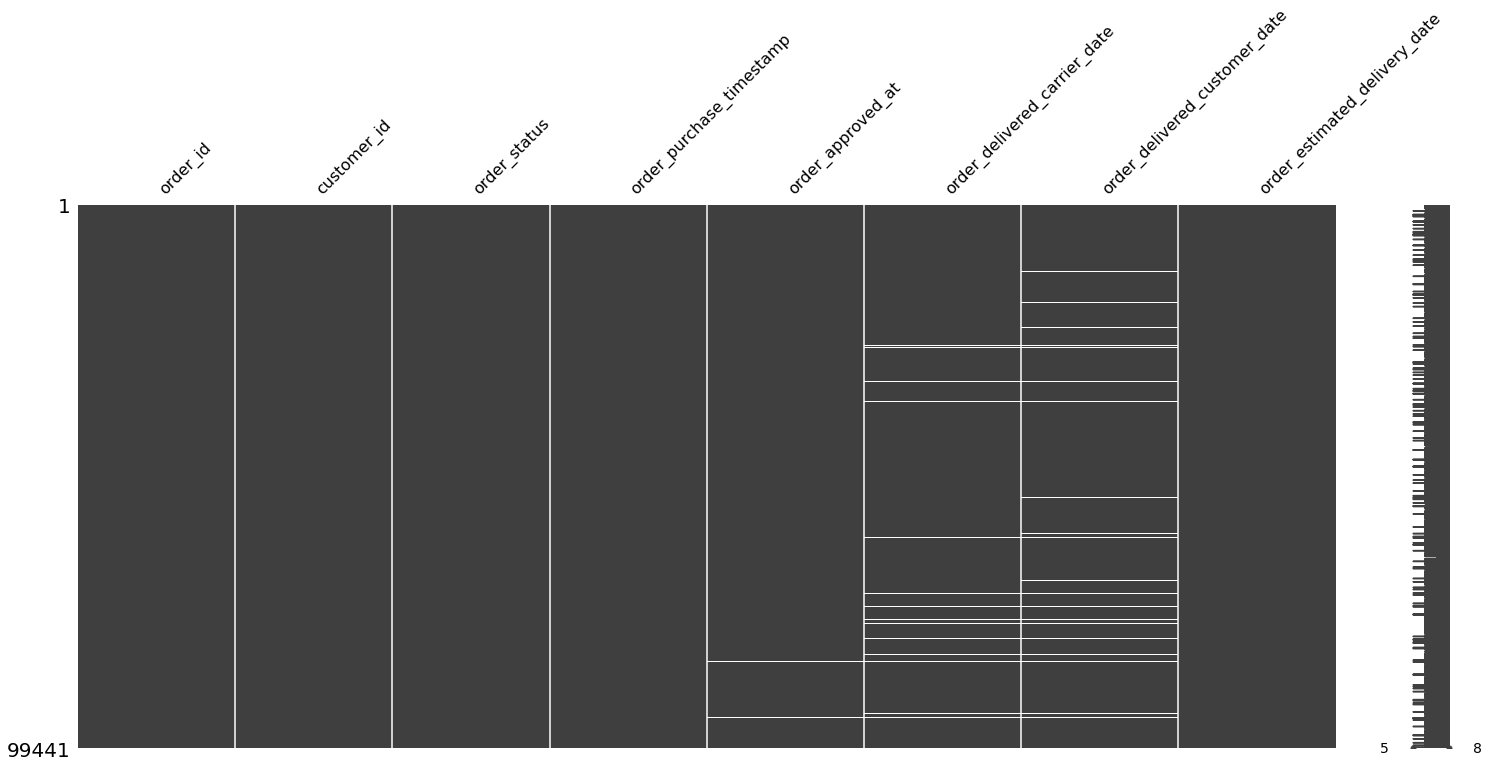

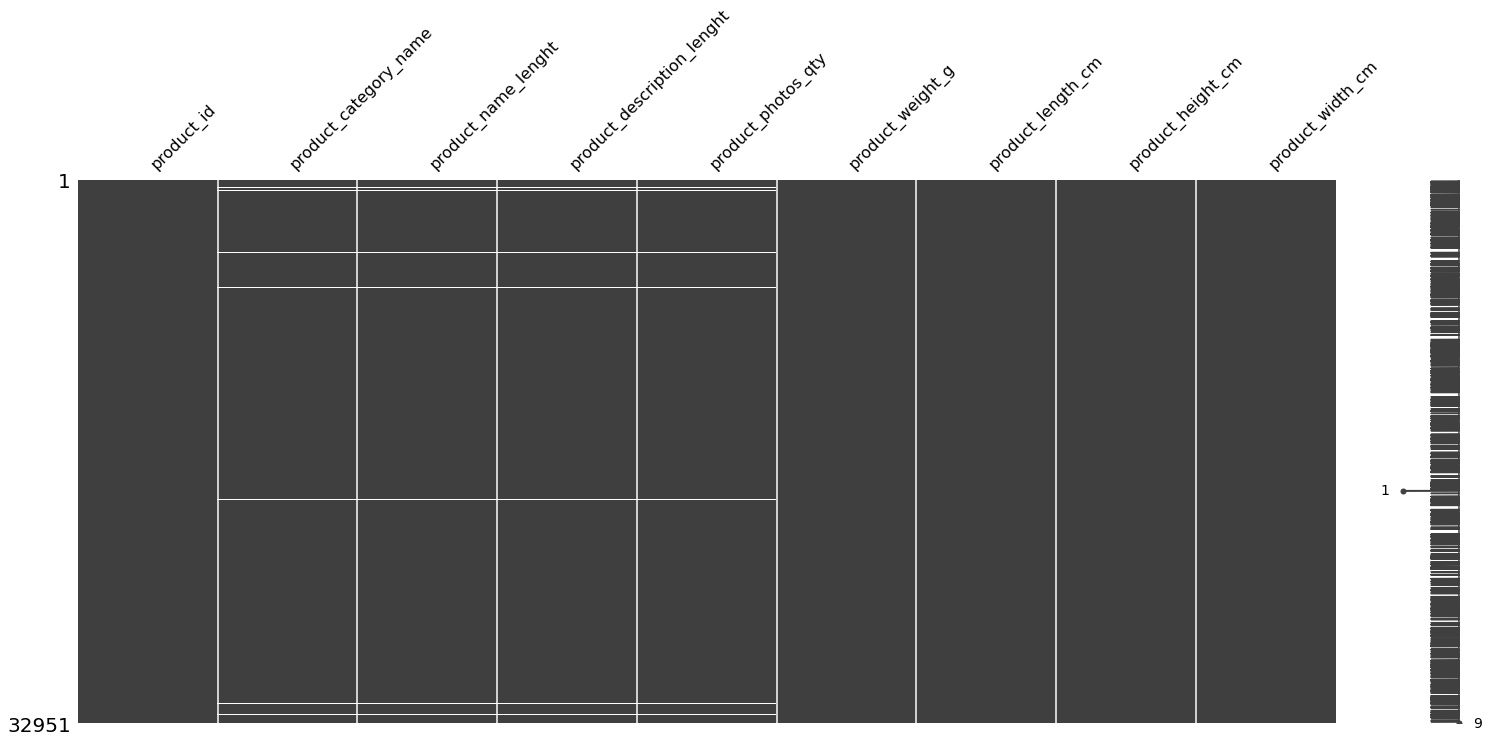

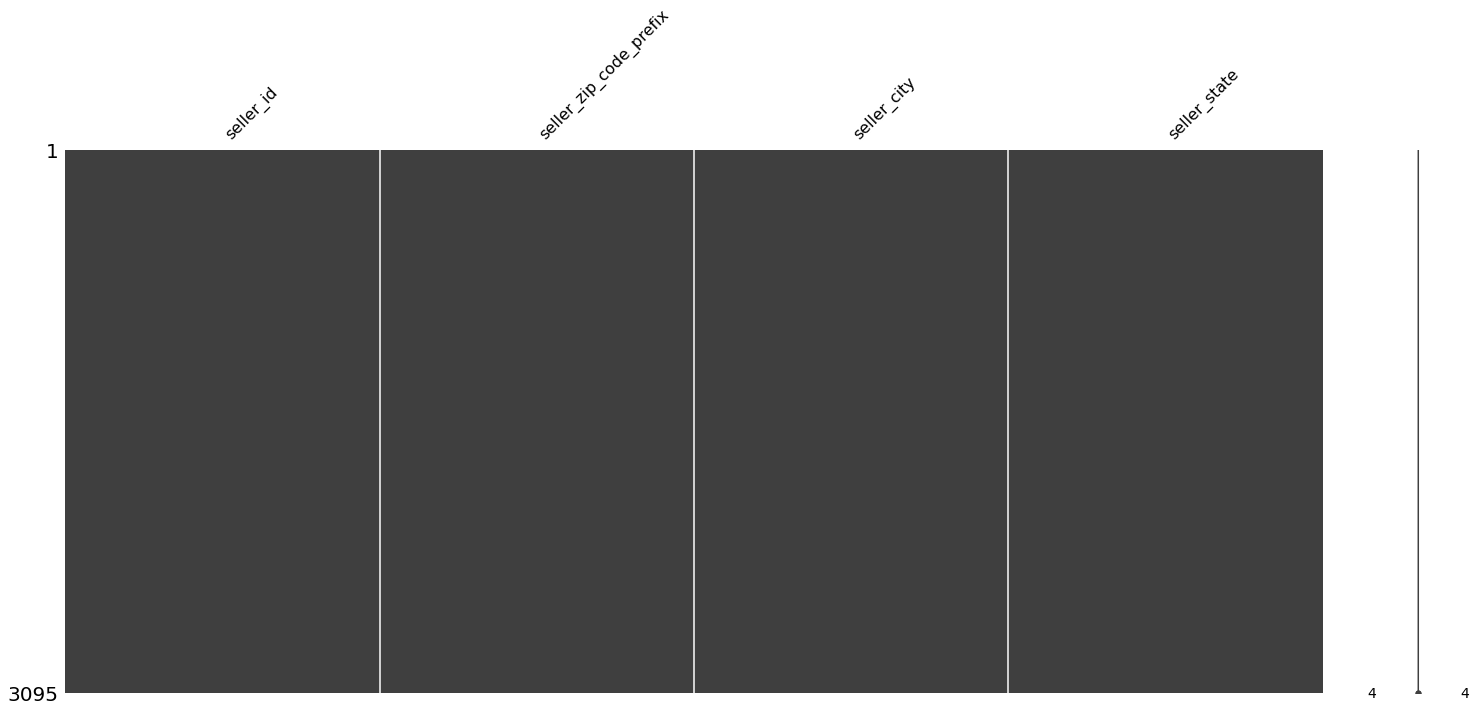

In [4]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])

In [5]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]
#get their review score
multi_rev_df = dfs[4][dfs[4]['order_id'].isin(multi_order_id)]

#get the category of each order
multi_prod_df =  dfs[2][dfs[2]['order_id'].isin(multi_order_id)]
multi_prod_id = multi_prod_df['product_id']
multi_cat_df = dfs[6][dfs[6]['product_id'].isin(multi_prod_id)].set_index('product_id')

cat_ser = multi_cat_df['product_category_name']
multi_prod_df = multi_prod_df.join(cat_ser, on = 'product_id')
multi_prod_df = multi_prod_df.dropna(subset = 'product_category_name') #74 product don't have a category name


In [6]:
multi_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7469 entries, 1 to 112630
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               7469 non-null   object 
 1   order_item_id          7469 non-null   int64  
 2   product_id             7469 non-null   object 
 3   seller_id              7469 non-null   object 
 4   shipping_limit_date    7469 non-null   object 
 5   price                  7469 non-null   float64
 6   freight_value          7469 non-null   float64
 7   product_category_name  7469 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 525.2+ KB


In [7]:
def cat_name(x):
    temp = set()
    for i in x:
        if i not in temp:
            temp.add(i)
    temp = str(temp)
    return temp

In [8]:
x = (1,1,1,1,1)
y = (1,2,3)
z = (1,2,2)

In [9]:
y[2]

3

In [10]:
multi_cat_df['product_category_name'].unique().shape

(71,)

In [11]:
x = dfs[0]['customer_id'].unique().shape[0]
y = dfs[0]['customer_unique_id'].unique().shape[0]
print(x,y, 1-(y/x))

99441 96096 0.033638036624732304


In [12]:
import time
import datetime

def days(x):
    td = time.time()
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400)
    return d

In [13]:
##build the working df of each order
#take the customer id
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
#take the value of each order
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum() #some order have voucher
df = df.join(temp, on = 'order_id')
#calculate the days since order of each order
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
#take the review score for each order
temp = pd.DataFrame(index = multi_rev_df.index)
temp['review_days'] = multi_rev_df['review_creation_date'].apply(days)
temp = temp.join(multi_rev_df[['order_id', 'review_score']])
agg_fun = {'review_days' : ['min'], 'review_score' : ['mean']}
temp = temp.groupby('order_id').agg(agg_fun)
df = df.join(temp, on = 'order_id', how='right')
df = df.drop(df.columns[5], axis=1 ) 
df = df.rename(columns = {df.columns[5] : 'review_score'})

#take the product category of each order
temp = pd.DataFrame(multi_prod_df.groupby('order_id').product_category_name.agg(lambda x: tuple(x)))

def cat_name(x):  #some orders have mulitple items from the same category
    y = set()
    for i in x:
        if i not in y:
            y.add(i)
    y = str(y)
    return y

temp['product_category_name'] = temp.applymap(cat_name)
df = df.join(temp, on = 'order_id')
df =df.dropna(subset = 'product_category_name')
df =  df[df.groupby('customer_unique_id').customer_unique_id.transform('count') > 1]#some customer didn't review all their orders
print(df.info(),df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5929 entries, f6dd3ec061db4e3987629fe6b26e5cce to c5d108ecadaedf367e995520d36c9b1d
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        5929 non-null   object 
 1   order_id                  5929 non-null   object 
 2   order_purchase_timestamp  5929 non-null   object 
 3   order_total               5929 non-null   float64
 4   days_since_order          5929 non-null   int64  
 5   review_score              5929 non-null   float64
 6   product_category_name     5929 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 370.6+ KB
None                                                 customer_unique_id  \
customer_id                                                          
f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
8085a9af46f619bc25966f151a362b0d  98758d88bf4b8eef1372ddee45d63178

E:\temp\ipykernel_34788\2430091187.py:18: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.join(temp, on = 'order_id', how='right')


In [14]:
pd.crosstab(df['customer_unique_id'], df['product_category_name'], values = df['product_category_name'], aggfunc= 'count', margins = True).fillna(0)

product_category_name,{'agro_industria_e_comercio'},"{'alimentos', 'pet_shop'}",{'alimentos'},"{'alimentos_bebidas', 'esporte_lazer'}","{'alimentos_bebidas', 'utilidades_domesticas'}",{'alimentos_bebidas'},{'artes'},{'artes_e_artesanato'},{'artigos_de_festas'},{'artigos_de_natal'},...,{'sinalizacao_e_seguranca'},{'tablets_impressao_imagem'},{'telefonia'},{'telefonia_fixa'},"{'utilidades_domesticas', 'bebes'}","{'utilidades_domesticas', 'esporte_lazer'}","{'utilidades_domesticas', 'moveis_cozinha_area_de_servico_jantar_e_jardim'}","{'utilidades_domesticas', 'moveis_decoracao'}",{'utilidades_domesticas'},All
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
004288347e5e88a27ded2bb23747066c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
004b45ec5c64187465168251cd1c9c2f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
0058f300f57d7b93c477a131a59b36c3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
00a39521eb40f7012db50455bf083460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
00cc12a6d8b578b8ebd21ea4e2ae8b27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff44401d0d8f5b9c54a47374eb48c1b8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
ff8892f7c26aa0446da53d01b18df463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
ff922bdd6bafcdf99cb90d7f39cea5b3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [15]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())

#feature  = number of order
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()

#feature  = total value of orders
md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')

#feature  = mean and std of orders
md_df['payment_mean'] = df.groupby('customer_unique_id').order_total.agg('mean')
md_df['payment_std'] = df.groupby('customer_unique_id').order_total.agg('std')

#feature frequency of order on the distrib
df['order_dis'] = pd.cut(df['order_total'],10, duplicates = 'drop')
temp = pd.crosstab(df['customer_unique_id'], df['order_dis'], values = df['order_dis'], aggfunc= 'count', margins = True)
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)
temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)

#feature frequency of category
temp = pd.crosstab(df['customer_unique_id'], df['product_category_name'], values = df['product_category_name'], aggfunc= 'count', margins = True).fillna(0)
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)
temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)
#feature review score mean and std
md_df['rev_mean'] = df.groupby('customer_unique_id').review_score.agg('mean')
md_df['rev_std'] = df.groupby('customer_unique_id').review_score.agg('std')
#feature  = days since last order
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')


print(md_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2808 entries, eb28e67c4c0b83846050ddfb8a35d051 to acc4424c209233de519e034152f30304
Columns: 139 entries, n_order to days_since_last_order
dtypes: float64(137), int64(2)
memory usage: 3.1+ MB
None


<AxesSubplot:>

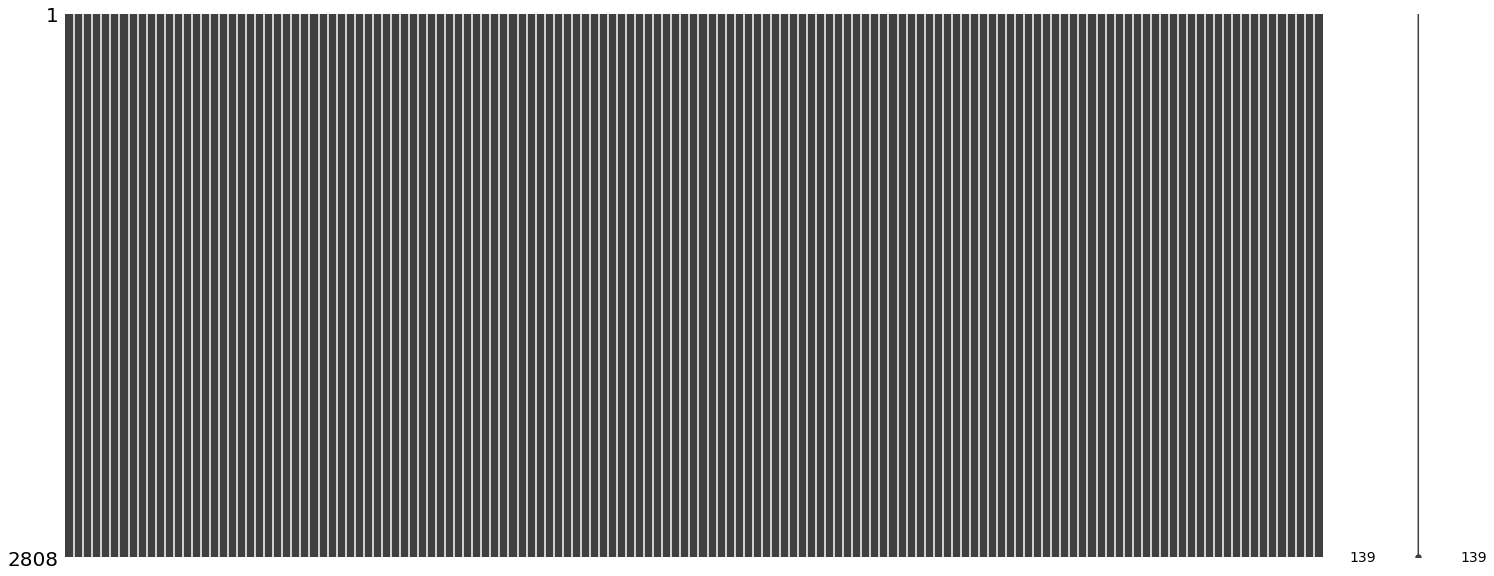

In [16]:
msno.matrix(md_df)

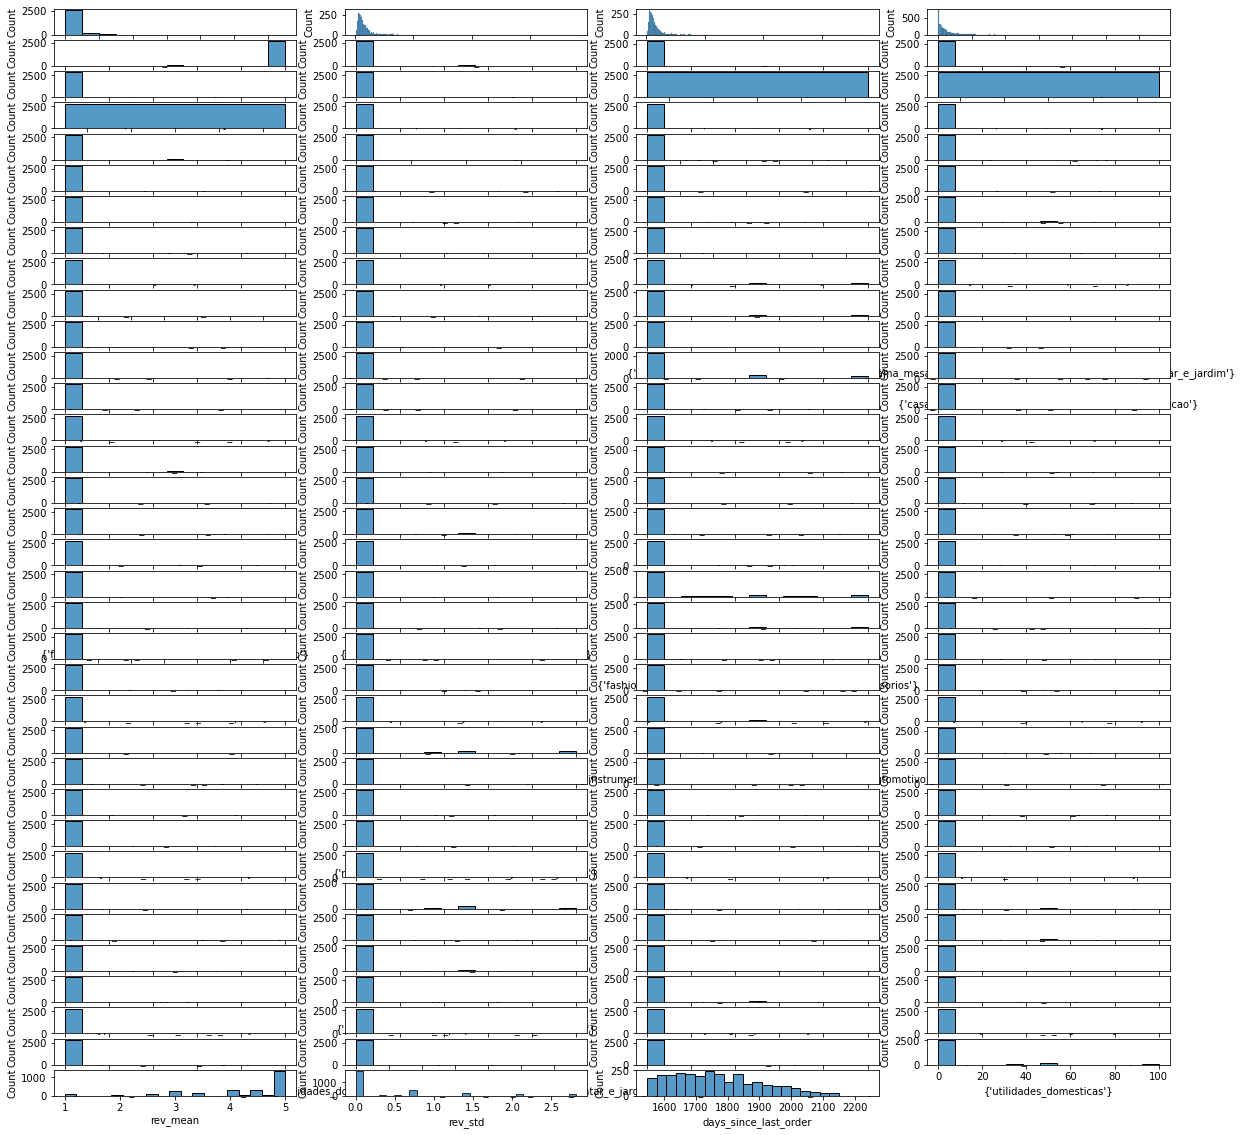

In [17]:

fig = plt.figure(figsize=(20,20))
for i in range(md_df.shape[1]):
    ax = fig.add_subplot(int((md_df.shape[1]/4)+1), 4, i+1)
    sns.histplot(md_df.iloc[:,i], ax = ax)

plt.show()

In [18]:
md_df.to_csv('md_df.csv', index = False)

## Dimention reduction

In [19]:
dim_df = pd.read_csv('md_df.csv')
x = dim_df.values
features = dim_df.columns

In [20]:
dim_df.isna().sum().sum()

0

In [21]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
x_scale = preprocessing.scale(x)

pca.fit(x_scale)

PCA(n_components=2)

In [22]:
scree = (pca.explained_variance_ratio_*100).round(2).cumsum()
print(scree)

[3.29 4.67]


In [23]:
pd.DataFrame(pca.components_, columns = features, index = ['F1', 'F2'])



,n_order,payment_total,payment_mean,payment_std,"(6.621, 505.438]","(505.438, 999.316]","(999.316, 1493.194]","(1493.194, 1987.072]","(1987.072, 2480.95]","(2480.95, 2974.828]",...,{'telefonia'},{'telefonia_fixa'},"{'utilidades_domesticas', 'bebes'}","{'utilidades_domesticas', 'esporte_lazer'}","{'utilidades_domesticas', 'moveis_cozinha_area_de_servico_jantar_e_jardim'}","{'utilidades_domesticas', 'moveis_decoracao'}",{'utilidades_domesticas'},rev_mean,rev_std,days_since_last_order
F1,0.028649,0.441678,0.449708,0.365127,-0.403980,0.279042,0.223809,0.138511,0.099177,0.225079,...,-0.018743,-0.006834,-0.001750,0.000424,0.001884,0.001107,-0.000914,-0.023886,0.023034,-0.011069
F2,-0.019548,0.017614,0.038210,-0.021002,0.241368,-0.254827,-0.215677,-0.081277,-0.061533,0.509584,...,-0.003933,0.002832,0.006062,-0.002928,0.000354,0.003899,-0.001028,0.114759,-0.124902,0.117255


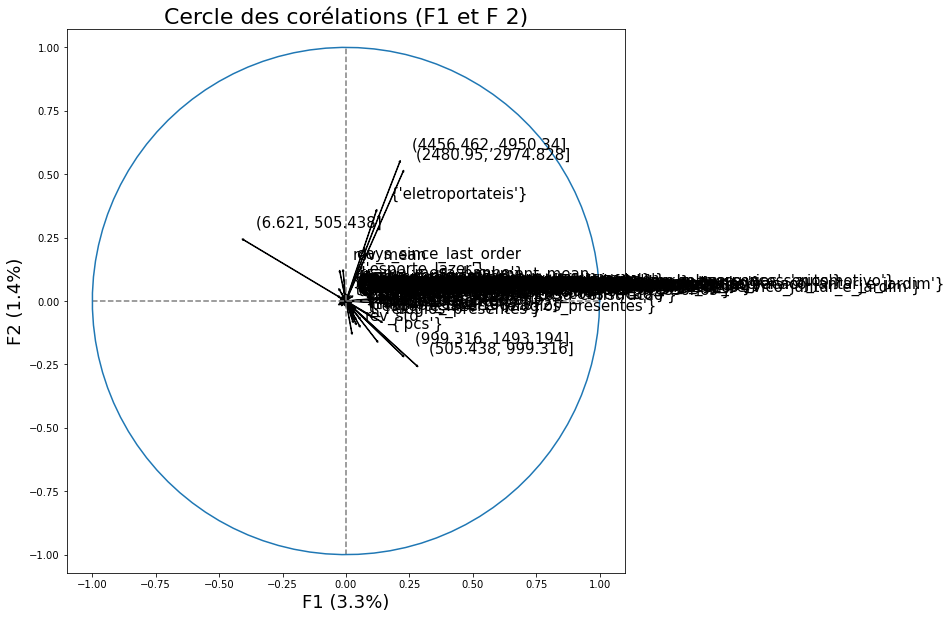

<Figure size 432x288 with 0 Axes>

In [24]:
x, y = 0,1 #define factorial space, (0,1) define the first factorial plane (F1, F2), (2,3) define the second (F3,F4) and so on(tuple)

fig, ax = plt.subplots(figsize = (10,10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0, #start the arrow at the origin
                    pca.components_[0,i], #coordinate for PC1
                    pca.components_[1,i], #coordinate for PC2
                    head_width = 0.007,
                    head_length = 0.007,
                    width=0.002,) #graphical aspect of the arrow
    plt.text(pca.components_[0,i] + 0.05,
                        pca.components_[1,i] + 0.05,
                        features[i], fontsize = 15) # plot the text near each arrow head
plt.plot([-1,1], [0,0], color = 'grey', ls='--')
plt.plot([0,0], [-1,1], color='grey', ls='--') #plot the lines (abscissa and ordonate)

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)), fontsize = 18) #label the axis with the percentage of explained variance
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)),fontsize = 18)

plt.title('Cercle des corélations (F{} et F {})'.format(x+1, y+1), fontsize = 22)

an = np.linspace(0, 2 * np.pi, 100) #return an np.array of the coordinates (100) of a circle of circonference 1 (2*pi)
plt.plot(np.cos(an), np.sin(an)) #plot the circle
plt.axis('equal') #set equal scaling
plt.show()
plt.clf()

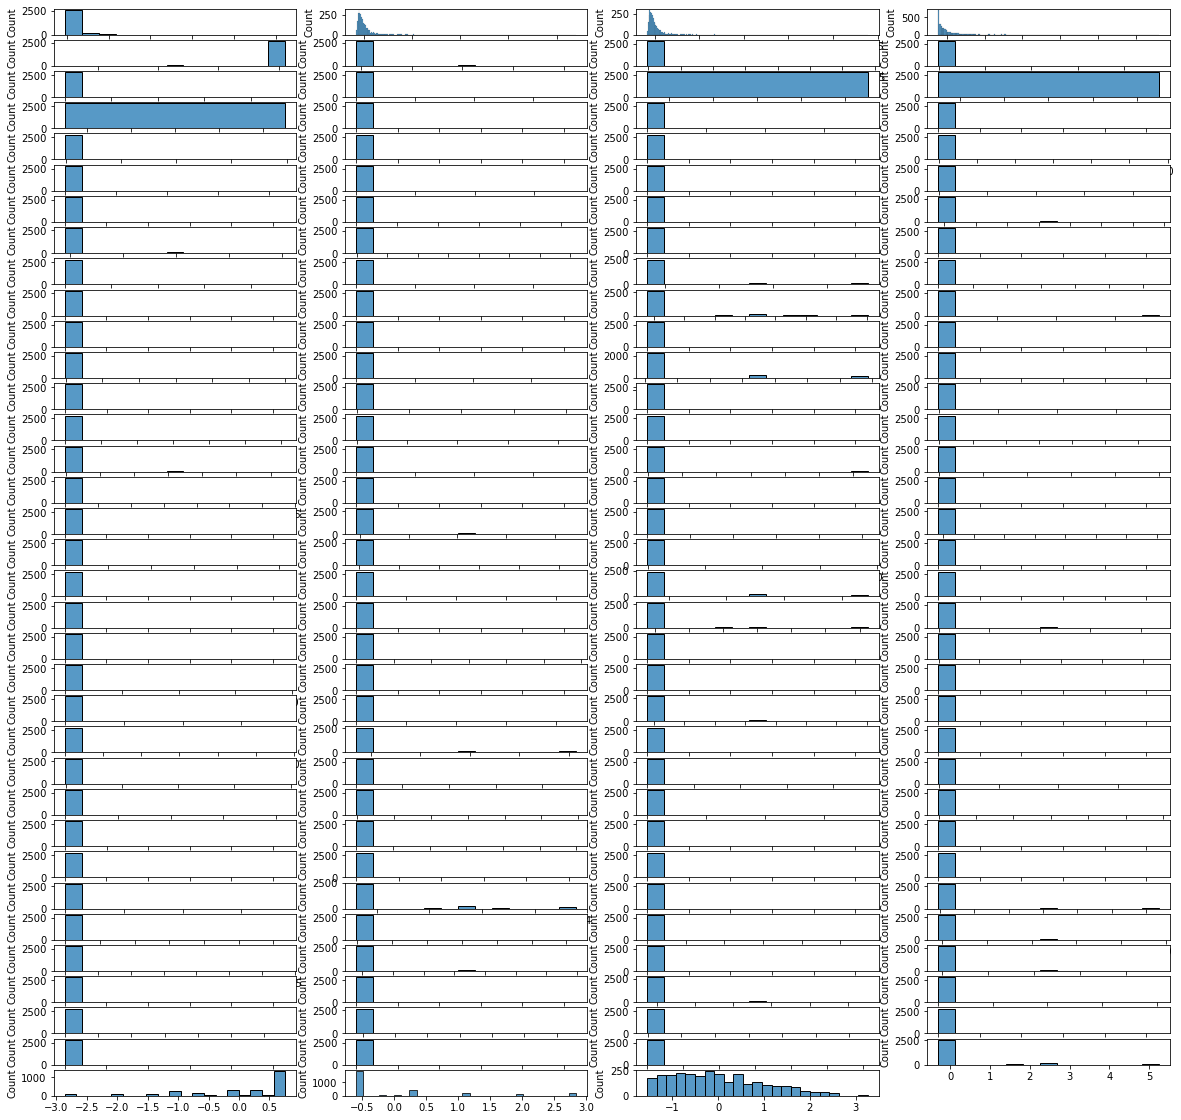

In [25]:
fig = plt.figure(figsize=(20,20))
for i in range(x_scale.shape[1]):
    ax = fig.add_subplot(int((x_scale.shape[1]/4)+1), 4, i+1)
    sns.histplot(x_scale[:,i], ax = ax)

plt.show()

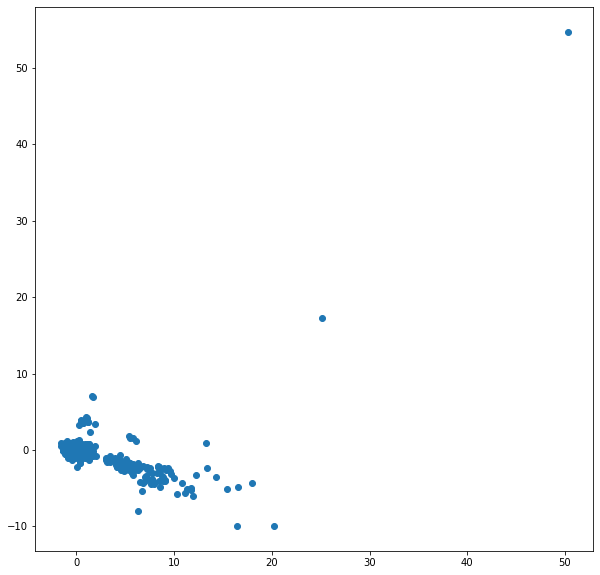

In [26]:
x_proj = pca.transform(x_scale)
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x_proj[:,0],x_proj[:,1])
plt.show()

In [27]:
from sklearn.manifold import Isomap
iso = Isomap()
from sklearn.manifold import MDS
mds = MDS()
from sklearn.manifold import TSNE
tsne = TSNE()

x_proj2 = mds.fit_transform(x_scale)
x_proj3 = tsne.fit_transform(x_scale)
#x_proj4 = iso.fit_transform(x_scale)

E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [28]:
from sklearn import cluster, metrics

Text(0.55, 0.4, 'Best silhouette : 0.59, Optimal Clus : 40')

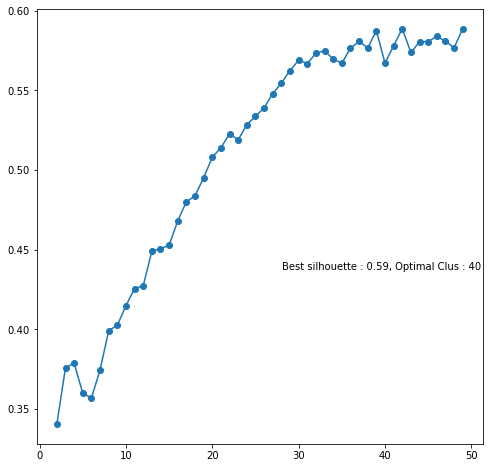

In [37]:
silhouette = []
for i in range(2,50):
    clus = cluster.KMeans(n_clusters = i)
    clus.fit(x_proj3)
    sil  = metrics.silhouette_score(x_proj3, clus.labels_)
    silhouette.append(sil)
max_sil = max(silhouette)
index = silhouette.index(max_sil)
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(range(2,50), silhouette, marker ='o')
ax.text(0.55,0.4,'Best silhouette : {:.2f}, Optimal Clus : {}'.format(max_sil, index), transform = ax.transAxes)

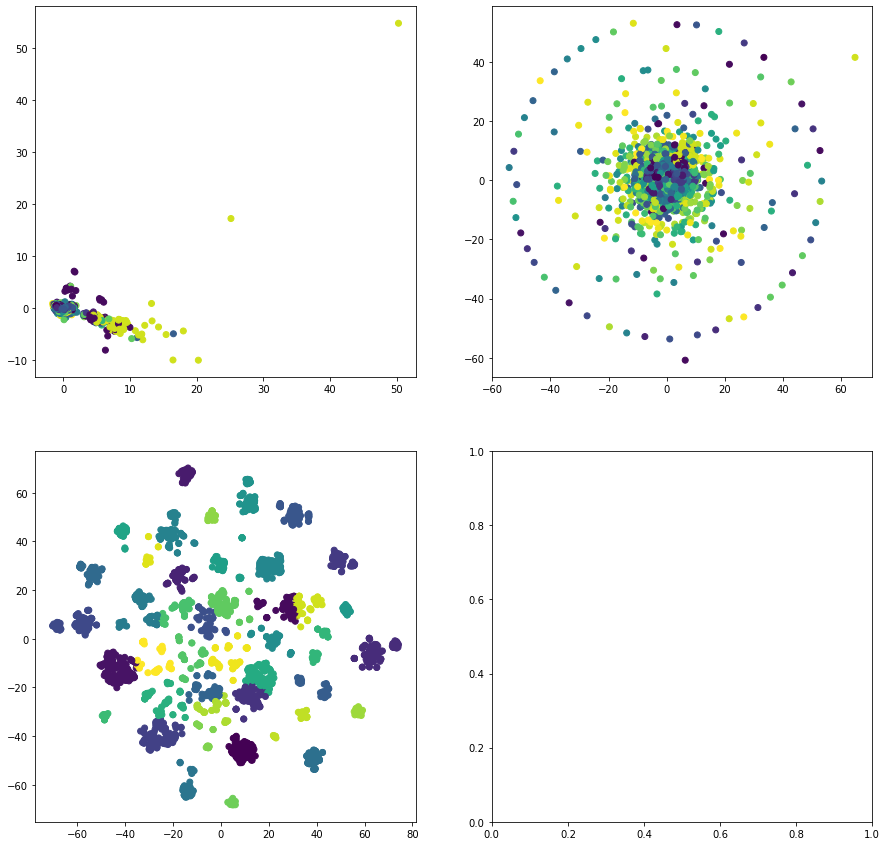

In [30]:
clus = cluster.KMeans(n_clusters = silhouette.index(max(silhouette)))
clus.fit(x_proj3)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=clus.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=clus.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=clus.labels_)

plt.show()

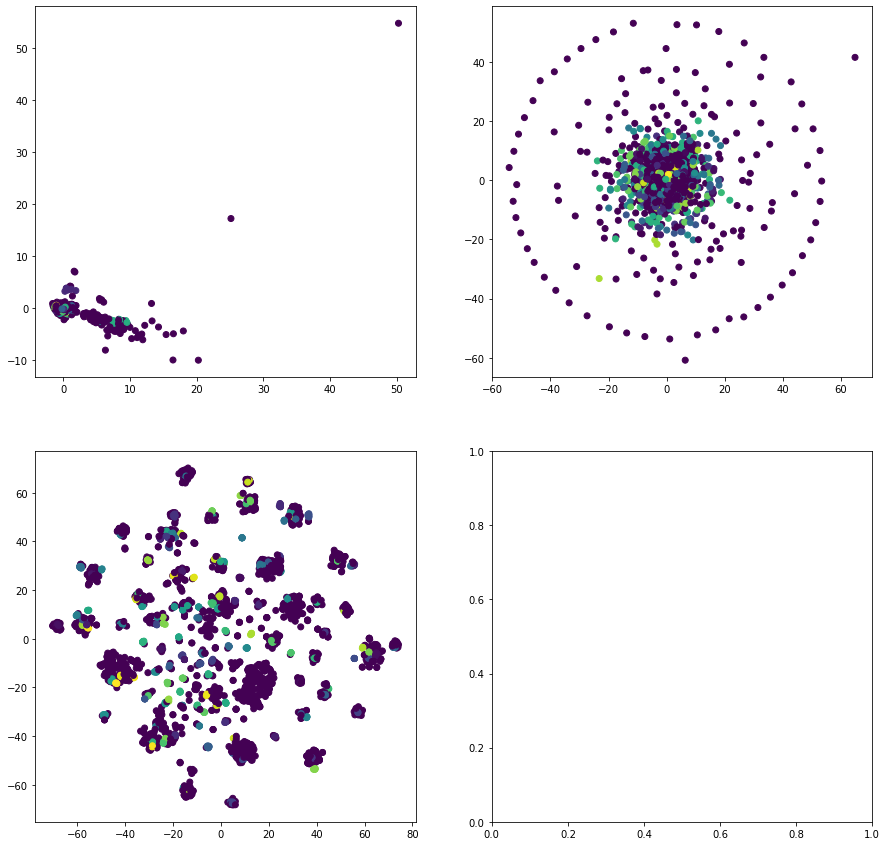

In [31]:
dbscan = cluster.DBSCAN()
dbscan.fit(x_proj3)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=dbscan.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=dbscan.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=dbscan.labels_)

plt.show()

In [32]:
md_df['clus_label'] = clus.labels_
md_df['dbscan_label'] = dbscan.labels_
print('KMeans have found {} clusters'.format(len(md_df['clus_label'].unique())))
print('BDscan have found {} clusters'.format(len(md_df['dbscan_label'].unique())))

KMeans have found 42 clusters
BDscan have found 142 clusters


In [33]:
temp = np.unique(clus.labels_)
print(len(temp))
md_df.loc[md_df['clus_label'] == 0].describe()

42


,n_order,payment_total,payment_mean,payment_std,"(6.621, 505.438]","(505.438, 999.316]","(999.316, 1493.194]","(1493.194, 1987.072]","(1987.072, 2480.95]","(2480.95, 2974.828]",...,"{'utilidades_domesticas', 'bebes'}","{'utilidades_domesticas', 'esporte_lazer'}","{'utilidades_domesticas', 'moveis_cozinha_area_de_servico_jantar_e_jardim'}","{'utilidades_domesticas', 'moveis_decoracao'}",{'utilidades_domesticas'},rev_mean,rev_std,days_since_last_order,clus_label,dbscan_label
count,106.000000,106.000000,106.000000,106.000000,106.0,106.0,106.0,106.0,106.0,106.0,...,106.0,106.0,106.0,106.0,106.0,106.000000,106.000000,106.000000,106.0,106.000000
mean,2.009434,271.296226,134.325550,50.036743,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.919025,0.389019,1845.971698,0.0,9.509434
std,0.097129,169.485762,81.276829,62.770248,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.320847,0.796820,176.261681,0.0,28.996961
min,2.000000,40.470000,20.235000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1555.000000,0.0,-1.000000
25%,2.000000,148.962500,74.481250,3.553212,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.000000,0.000000,1701.750000,0.0,-1.000000
50%,2.000000,222.725000,111.362500,26.180629,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.500000,0.000000,1833.000000,0.0,-1.000000
75%,2.000000,361.117500,180.558750,65.642490,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.000000,0.353553,2014.500000,0.0,-1.000000
max,3.000000,841.150000,392.940000,292.742207,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.000000,2.828427,2237.000000,0.0,129.000000


In [34]:
temp = np.unique(dbscan.labels_)
print(temp)
#for i in temp:
    #print(i,md_df.loc[md_df['dbscan_label'] == i].describe())

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140]
